# Skeleton pytorch with PyPSA data

In [113]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# from torchvision.utils import make_grid
import pandas as pd

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12,4)
# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Logging ML
from torch.utils.tensorboard import SummaryWriter
import wandb

In [114]:
config = dict(    
    learning_rate =1e-3,
    batch_size =128,
    epochs = int(3e3),
    model="nn1",
    training_loss = "MSE",
    year="2014",
    year_val="2012",
    nodes="37"
)
use_tb = False
use_wandb= True
manual_logging = False

random_seed = 746435
torch.manual_seed(random_seed)

In [115]:
dir_root = Path("../") # go to root of git repo
dir_data = dir_root / "data"
dir_data_ml= dir_data /"ml"
dir_models = dir_root / "models"
dir_runs = dir_root/"runs"
dir_runs_tb = dir_runs /"tb"
dir_runs_wandb = dir_root / "wandb"
param_save = "002_01_simplest"

network_name = f"elec_s_{config['nodes']}_ec_lcopt_Co2L-3H"

dir_training_set = dir_data_ml / config["year"]/ "3M"
filename_inputs_tr = dir_training_set / f"{network_name}_inputs.P"
filename_outputs_tr = dir_training_set / f"{network_name}_outputs_p.P"

dir_val_set = dir_data_ml / config["year_val"]/ "3M"
filename_inputs_val = dir_val_set / f"{network_name}_inputs.P"
filename_outputs_val = dir_val_set / f"{network_name}_outputs_p.P"

for fn in [filename_inputs_tr, filename_outputs_tr]:
    print(f"{fn}: {'Exists' if fn.exists() else 'Missing'}")

../data/ml/2014/3M/elec_s_37_ec_lcopt_Co2L-3H_inputs.P: Exists
../data/ml/2014/3M/elec_s_37_ec_lcopt_Co2L-3H_outputs_p.P: Exists


In [116]:
if use_tb: tb_writer= SummaryWriter(log_dir=dir_runs_tb)
if use_wandb: wandb.init(project="phd-ph5x-02-002_power_prediction",dir=dir_runs,config=config)


### Load data

In [117]:
df_input_tr = pd.read_pickle(filename_inputs_tr)
df_output_tr = pd.read_pickle(filename_outputs_tr)
df_input_val = pd.read_pickle(filename_inputs_val)
df_output_val = pd.read_pickle(filename_outputs_val)


assert (df_input_val.columns==df_input_tr.columns).all(), "Mismatch in input columns"
assert (df_output_val.columns==df_output_tr.columns).all(), "Mismatch in output columns"

x_train = torch.from_numpy(df_input_tr.values.astype("float32"))
y_train = torch.from_numpy(df_output_tr.values.astype("float32"))
x_mean = x_train.mean(dim = 0)
x_std =x_train.std(dim = 0)
# y_mean = #  centered already
y_std = y_train.std(dim = 0)

x_train =(x_train - x_mean)/x_std
y_train /= y_std

x_val = torch.from_numpy(df_input_val.values.astype("float32"))
y_val = torch.from_numpy(df_output_val.values.astype("float32"))
x_val =(x_val - x_mean)/x_std
y_val /= y_std
assert not(((x_val[0:100]-x_train[0:100])<1e-5).all())

n_input = x_train.shape[1]
n_output = y_train.shape[1]
n_samples_tr = x_train.shape[0]
n_samples_val = x_val.shape[0]
(n_input,n_output,n_samples_tr,n_samples_val)
# train_loader = load

(219, 37, 2920, 2928)

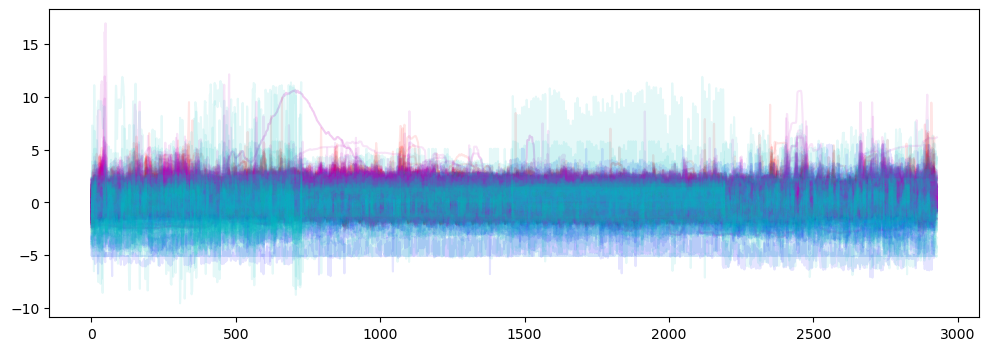

In [118]:
_=plt.plot(x_train, "r", alpha = 0.1) # [:,38:192]
_=plt.plot(y_train, "b", alpha = 0.1) # [:,38:192]
_=plt.plot(x_val, "m", alpha = 0.1) # [:,38:192]
_=plt.plot(y_val, "c", alpha = 0.1) # [:,38:192]


### Define Model

In [119]:


## Full model
class PowerModel(nn.Module):
    """Feedfoward neural network (0 layers)"""
    def __init__(self, in_size,  out_size, hidden_size=None):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # output layer
        self.linear3 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # # Apply activation function
        out = F.relu(out)
        # # Get predictions using output layer
        out = self.linear2(out)
        out = F.relu(out)
        # # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    # def training_step(self, batch):
    #     inputs, targets = batch 
    #     out = self(inputs)                  # Generate predictions
    #     loss = F.cross_entropy(out, targets) # Calculate loss
    #     return loss
    
    # def validation_step(self, batch):
    #     inputs, targets = batch 
    #     out = self(inputs)                    # Generate predictions
    #     loss = F.cross_entropy(out, targets)   # Calculate loss
    #     # acc = accuracy(out, labels)           # Calculate accuracy
    #     return loss

        
    # def validation_epoch_end(self, outputs):
    #     batch_losses = outputs
    #     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    #     # batch_accs = [x['val_acc'] for x in outputs]
    #     # epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    #     return  epoch_loss.item()

    # def epoch_end(self,epoch,result):
    #     print(f"Epoch [{epoch}], val_loss: { result['val_loss'] :.4f}") #, val_acc: {result['val_acc']:.4f}")
        

### Instantiate and run

In [120]:

# NN regression model
if config["model"]=="linear":
    model = nn.Linear(n_input,n_output)
elif config["model"]=="nn1":
    model =  PowerModel(n_input,n_output,hidden_size=64)
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.MSELoss()  
# criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

In [121]:
# Train the model
if manual_logging: losses=[]
for epoch in range(config["epochs"]):

    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    outputs_val = model(x_val)
    loss_val = criterion(outputs_val, y_val)
    diff_loss= loss_val-loss
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # model.epoch_end(epoch,loss)
    
    # Logging
    if manual_logging: losses.append(loss.item())
    if use_wandb: wandb.log(dict(
        loss=loss,loss_val=loss_val,diff_loss=diff_loss))
    if use_tb:
        tb_writer.add_scalar("Loss/train", loss, epoch)
        tb_writer.add_scalar("Loss/val", loss_val, epoch)
    # Printing
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}], Loss: { loss.item() :.7f}, Val_loss: {loss_val.item() :.5f}")
        

if use_wandb: wandb.finish()
if use_tb:
    tb_writer.flush()
    tb_writer.close()

Epoch [100], Loss: 0.5091643, Val_loss: 2.33826
Epoch [200], Loss: 0.3445551, Val_loss: 2.34882
Epoch [300], Loss: 0.2750273, Val_loss: 2.35442
Epoch [400], Loss: 0.2385504, Val_loss: 2.36453
Epoch [500], Loss: 0.2153595, Val_loss: 2.37253
Epoch [600], Loss: 0.1977798, Val_loss: 2.38270
Epoch [700], Loss: 0.1842111, Val_loss: 2.38480
Epoch [800], Loss: 0.1735349, Val_loss: 2.39662
Epoch [900], Loss: 0.1648612, Val_loss: 2.40944
Epoch [1000], Loss: 0.1575585, Val_loss: 2.42050
Epoch [1100], Loss: 0.1512316, Val_loss: 2.42889
Epoch [1200], Loss: 0.1457144, Val_loss: 2.43750
Epoch [1300], Loss: 0.1408241, Val_loss: 2.46032
Epoch [1400], Loss: 0.1365094, Val_loss: 2.48106
Epoch [1500], Loss: 0.1328273, Val_loss: 2.50745
Epoch [1600], Loss: 0.1297075, Val_loss: 2.53745
Epoch [1700], Loss: 0.1268721, Val_loss: 2.55980
Epoch [1800], Loss: 0.1243325, Val_loss: 2.59003
Epoch [1900], Loss: 0.1220587, Val_loss: 2.61721
Epoch [2000], Loss: 0.1199549, Val_loss: 2.64082
Epoch [2100], Loss: 0.1181050

diff_loss,▁▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,▅▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
diff_loss,2.73231
loss,0.10641
loss_val,2.83872


### Export

In [122]:
# # Save and load the entire model.
# torch.save(model, dir_models/f'{param_save}_model.ckpt')
# # model = torch.load('model.ckpt')

# # Save and load only the model parameters (recommended).
# torch.save(model.state_dict(), dir_models/f'{param_save}_params.ckpt')
# # resnet.load_state_dict(torch.load('params.ckpt'))

### Plot training

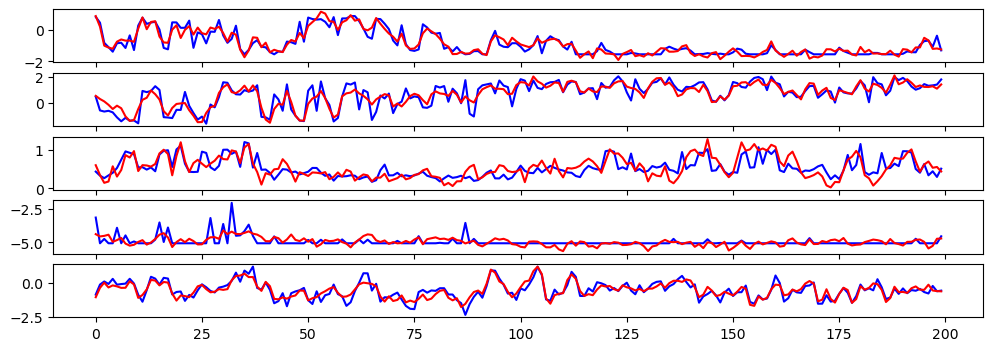

In [123]:
with torch.no_grad():
    fig,axes =plt.subplots(5)
    for i, ax in enumerate(axes):
        ax.plot(y_train[:200,i+10],"b")
        ax.plot(outputs[:200,i+10],"r")

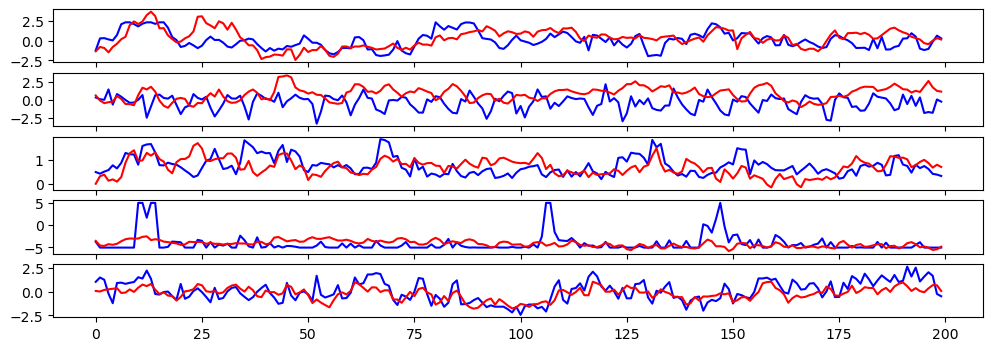

In [124]:
with torch.no_grad():
    fig,axes =plt.subplots(5)
    for i, ax in enumerate(axes):
        ax.plot(y_val[:200,i+10],"b")
        ax.plot(outputs_val[:200,i+10],"r")

In [125]:
criterion(outputs,y_train)

tensor(0.1064, grad_fn=<MseLossBackward0>)

In [126]:
criterion(outputs[:10],y_train[:10])

tensor(0.1167, grad_fn=<MseLossBackward0>)

In [127]:
((y_train-y_val).abs()<1e-5).all()

RuntimeError: The size of tensor a (2920) must match the size of tensor b (2928) at non-singleton dimension 0